# Portolio allocation focusing on Chinese Companies that trade on U.S. stock exchanges

In [1]:
# package
import os
import sys
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1.  Stock picking, input the dataset and calculate the compound return

We started with a selection of Chinese company stocks listed before 2016. Then we selected the top 6 stocks in terms of Sharpe Ratio. After selection, we input the dataset from Yahoo finance.The stock infomation data is from Wind website.

In [2]:
df=pd.read_csv("StockInfoData.csv").dropna()
df["listed_date"]=pd.to_datetime(df["listed_date"])
df = df.set_index("listed_date")
df.head()

,symbol
listed_date,
1991-08-07,NTP.N
1993-07-26,SHI.N
1994-10-05,HNP.N
1994-12-16,CYD.N
1995-03-10,CHNR.O


In [3]:
#extract the data before 2017
data_before_2017=df[:'2016']
data_before_2017=data_before_2017.reset_index()
data_before_2017.tail()

,listed_date,symbol
109,2016-10-17,YUMC.N
110,2016-10-27,ZTO.N
111,2016-11-02,GDS.O
112,2016-11-15,MOXC.O
113,2016-12-27,NISN.O


In [4]:
#extract the symbol of stock
name=data_before_2017["symbol"]
f = lambda x: x[:-2]
name=name.apply(f)
#change the datatype to list
name=name.values.tolist()
name[:6]

['NTP', 'SHI', 'HNP', 'CYD', 'CHNR', 'DSWL']

In [5]:
#download data
prices_df = yf.download(name, start="2017-01-01",end="2021-06-30", adjusted=True)
prices_df['Adj Close'].head()

[*********************100%***********************]  114 of 114 completed


,AACG,ACH,AEHL,AMBO,ANTE,ATCO,ATHM,BABA,BGNE,BIDU,...,VIPS,VNET,WB,XIN,XNET,YRD,YUMC,YY,ZNH,ZTO
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.377877,10.33,6.87,NaN,12.40,7.316923,24.879387,88.599998,31.049999,168.300003,...,11.23,7.10,41.549999,3.738967,3.95,20.463732,25.371569,38.589111,25.112797,11.641806
2017-01-04,0.382672,10.53,6.51,NaN,12.25,7.432090,24.791920,90.510002,31.770000,171.960007,...,11.22,7.02,43.200001,3.709926,3.91,20.962381,25.738993,37.268570,26.109259,11.718210
2017-01-05,0.374041,10.78,6.54,NaN,12.30,7.401381,26.492657,94.370003,31.020000,177.470001,...,11.40,7.46,44.939999,3.673624,3.94,21.767887,26.096746,39.508598,26.492516,12.386729
2017-01-06,0.364450,10.57,6.45,NaN,12.40,7.362988,26.638435,93.889999,30.809999,176.380005,...,11.69,7.38,44.750000,3.644584,3.88,21.461027,25.294218,39.498821,26.023027,12.740091
2017-01-09,0.353900,10.37,6.24,NaN,12.30,7.915791,27.318731,94.720001,31.530001,177.160004,...,11.64,7.20,45.130001,3.680885,3.95,21.403490,25.187855,39.264057,26.051773,12.415380


In [6]:
#Calculate the sharpe ratio
returns_df = prices_df['Adj Close'].pct_change().dropna()
returns_average_yearly=((1+returns_df.mean())**(252))- 1
stdYearly_df = returns_df.std() * (252 ** 0.5)
Sharpe_Ratio=returns_average_yearly / stdYearly_df
Sharpe_Ratio=Sharpe_Ratio.sort_values(ascending=False)
Sharpe_Ratio[:6,] # asset=["SPI","AACG","BTB","MOXC","DQ","RENN"]

SPI     10.812915
AACG     7.763900
BTB      4.257763
MOXC     2.282048
DQ       2.181347
RENN     2.134340
dtype: float64

In [7]:
prices_df=prices_df['Adj Close']

In [8]:
asset=["SPI","AACG","BTB","MOXC","DQ","RENN"]
prices_df=prices_df.loc[:,asset]
prices_df.head()

,SPI,AACG,BTB,MOXC,DQ,RENN
Date,,,,,,
2017-01-03,18.700001,0.377877,0.763,16.000000,3.970,2.147685
2017-01-04,18.900000,0.382672,0.800,16.200001,3.952,2.202404
2017-01-05,18.200001,0.374041,0.790,16.250000,4.044,2.284481
2017-01-06,18.100000,0.364450,0.781,16.150000,4.094,2.325519
2017-01-09,18.400000,0.353900,0.782,16.000000,4.122,2.366558


In [9]:
#compound return
vt1=prices_df
vt=vt1.shift(1)
compound_return=np.log(vt1/vt).dropna()

In [10]:
compound_return.head()

,SPI,AACG,BTB,MOXC,DQ,RENN
Date,,,,,,
2017-01-04,0.010638,0.012610,0.047354,0.012423,-0.004544,0.025159
2017-01-05,-0.037740,-0.022815,-0.012579,0.003082,0.023013,0.036589
2017-01-06,-0.005510,-0.025976,-0.011458,-0.006173,0.012288,0.017805
2017-01-09,0.016439,-0.029374,0.001280,-0.009331,0.006816,0.017493
2017-01-10,0.005420,-0.010899,0.010178,0.000000,0.000485,-0.035298


## 2. Drawing  Efficientcy frontier by Manto Carlo

In [11]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ["SPI","AACG","BTB","MOXC","DQ","RENN"]
RISKY_ASSETS.sort()
n_assets = len(RISKY_ASSETS)

In [12]:
np.random.seed(312)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [13]:
returns_df = prices_df.pct_change().dropna()
returns_df= returns_df[RISKY_ASSETS]
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [14]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [15]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [16]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

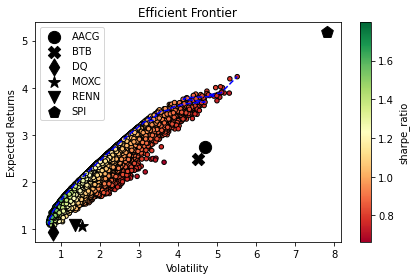

In [17]:
#plot
MARKS = ['o', 'X', 'd', '*','v','p']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [19]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 135.79% volatility: 75.55% sharpe_ratio: 179.73% 
Weights
AACG: 6.93% BTB: 4.57% DQ: 48.60% MOXC: 16.40% RENN: 19.57% SPI: 3.94% 

In [20]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 114.99% volatility: 68.80% sharpe_ratio: 167.15% 
Weights
AACG: 3.40% BTB: 2.32% DQ: 48.42% MOXC: 11.22% RENN: 33.67% SPI: 0.97% 

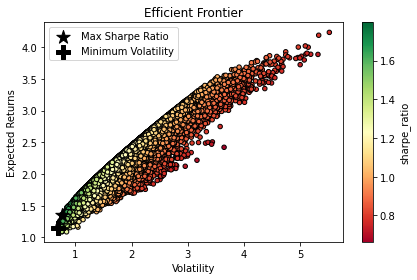

In [21]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

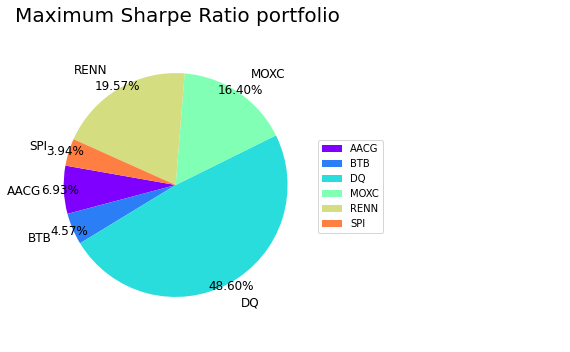

In [22]:
 #  pie chart of  SR portfolio
    
from matplotlib import font_manager as fm
from  matplotlib import cm

labels = RISKY_ASSETS
sizes = weights[np.argmax(portf_results_df.sharpe_ratio)]
explode = (0,0,0,0,0,0)  

fig, axes = plt.subplots(figsize=(8,5),ncols=2) 
ax1, ax2 = axes.ravel()

colors = cm.rainbow(np.arange(len(sizes))/len(sizes)) 
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.2f%%',explode=explode,
        shadow=False, startangle=170, colors=colors, labeldistance=1.2,pctdistance=1.03, radius=0.4)

ax1.axis('equal')  

proptease = fm.FontProperties()
proptease.set_size('large')

plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

ax1.set_title('Maximum Sharpe Ratio portfolio', loc='center',fontsize=20)
ax2.axis('off')
ax2.legend(patches, labels, loc='center left')

plt.tight_layout()
plt.savefig('Demo_project_final.jpg')
plt.show()

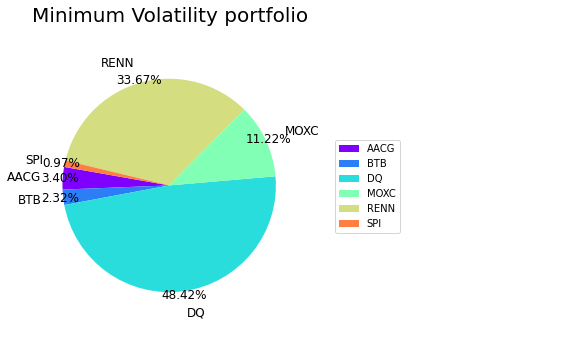

In [23]:
 #  pie chart of  MV portfolio

from matplotlib import font_manager as fm
from  matplotlib import cm

labels = RISKY_ASSETS
sizes = weights[np.argmin(portf_results_df.volatility)]
explode = (0,0,0,0,0,0)  

fig, axes = plt.subplots(figsize=(8,5),ncols=2) #
ax1, ax2 = axes.ravel()

colors = cm.rainbow(np.arange(len(sizes))/len(sizes)) # colormaps: Paired, autumn, rainbow, gray,spring,Darks
patches, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.2f%%',explode=explode,
        shadow=False, startangle=170, colors=colors, labeldistance=1.2,pctdistance=1.03, radius=0.4)

ax1.axis('equal')  

proptease = fm.FontProperties()
proptease.set_size('large')

plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

ax1.set_title('Minimum Volatility portfolio', loc='center',fontsize=20)
ax2.axis('off')
ax2.legend(patches, labels, loc='center left')

plt.tight_layout()
plt.savefig('Demo_project_final.jpg')
plt.show()

## 3. Invarient Visualize test of compound return.

Then we do the visulize test for chechking whether each srock's retrun are invarient.According to the plot, the distribution of two hisograms are similar and the scatter plot of each stock are looks like a circle. Therfore, all the compound returns are invarient. 

In [24]:
# def a fucntion for Visualize test
def Vtest(name,data,t=1,figsize=(20, 10), style='bmh'):
    new= data[name].reset_index(drop=True)
    flag0=0
    flag1=int(len(data)/2)
    flag2=int(len(data))
    name1=new.iloc[flag0:flag1].reset_index(drop=True)
    name2=new.loc[flag1:flag2].reset_index(drop=True)
    with plt.style.context(style): 
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        hist1_ax = plt.subplot2grid(layout, (0, 0))
        name1.plot.hist(ax=hist1_ax,bins=np.arange(min(name1), max(name1) + 0.01, 0.01))
        hist2_ax = plt.subplot2grid(layout, (0, 1))
        name2.plot.hist(ax=hist2_ax,bins=np.arange(min(name1), max(name1) + 0.01, 0.01))
        s_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
        s_ax.scatter(x=new[0:(flag2-t),],y=new[t:flag2,]) 
        plt.tight_layout()
        plt.suptitle(name)
    return

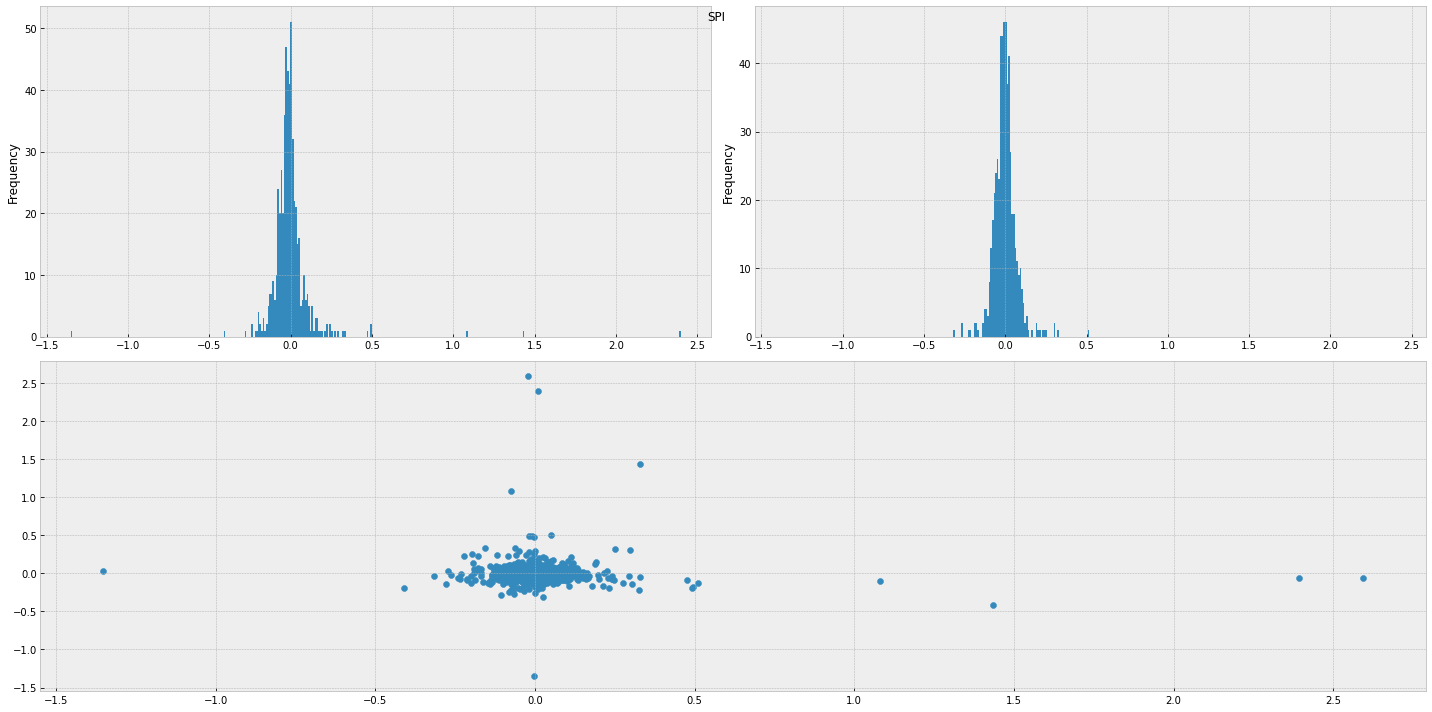

In [25]:
Vtest("SPI",compound_return)

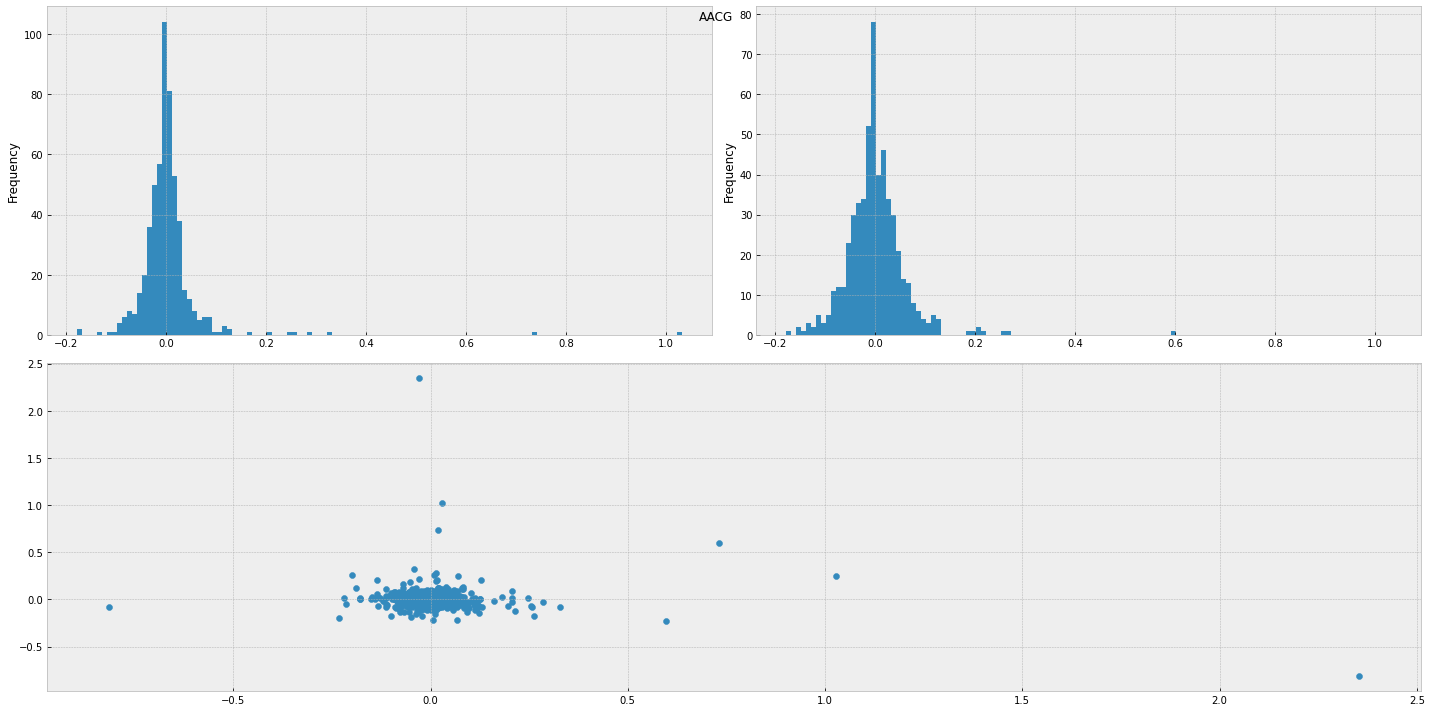

In [26]:
Vtest("AACG",compound_return)

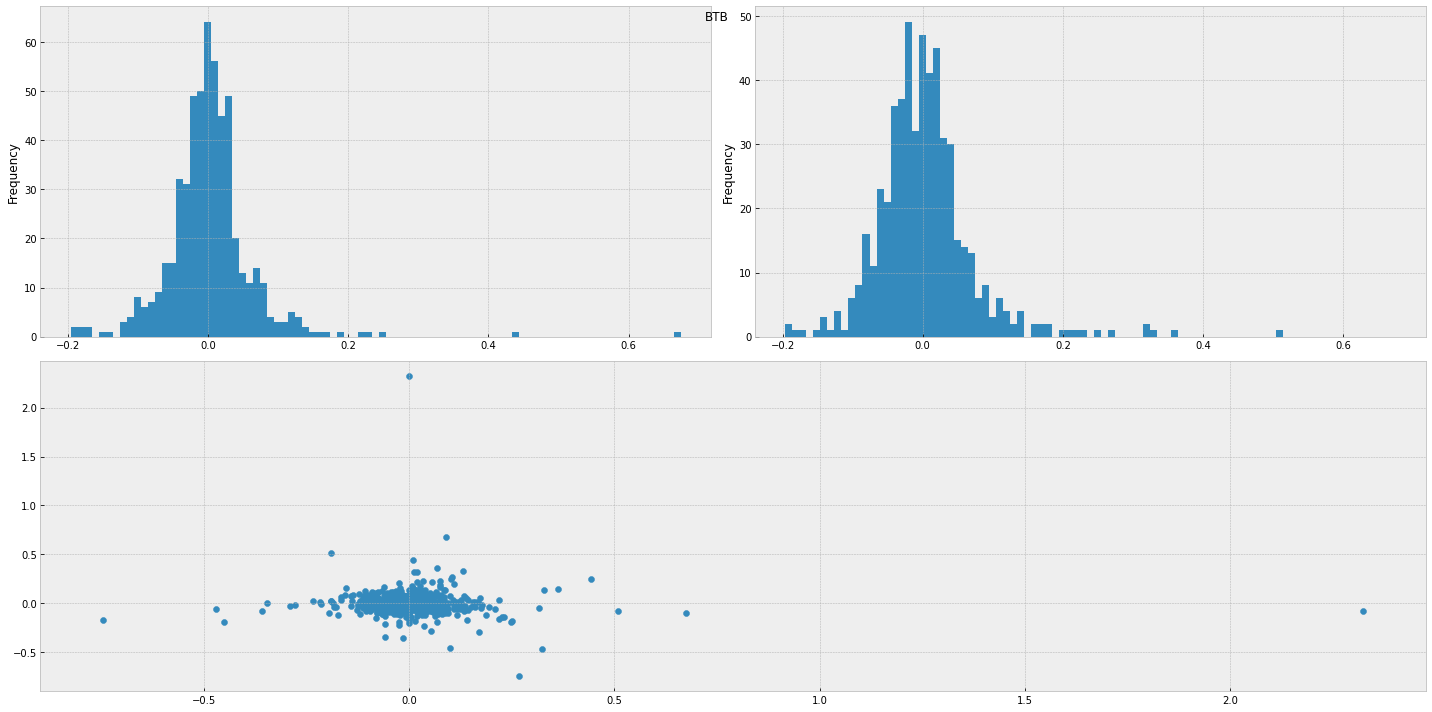

In [27]:
Vtest("BTB",compound_return)

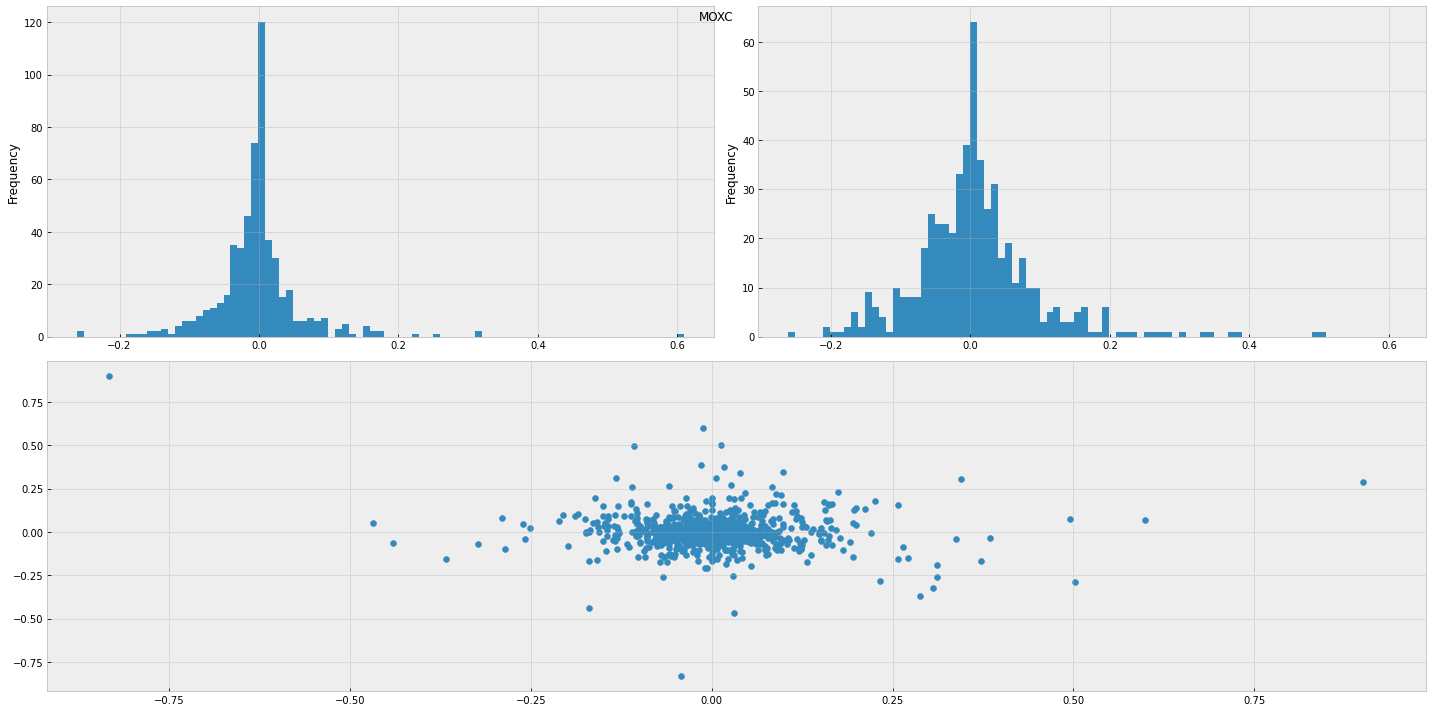

In [28]:
Vtest("MOXC",compound_return)

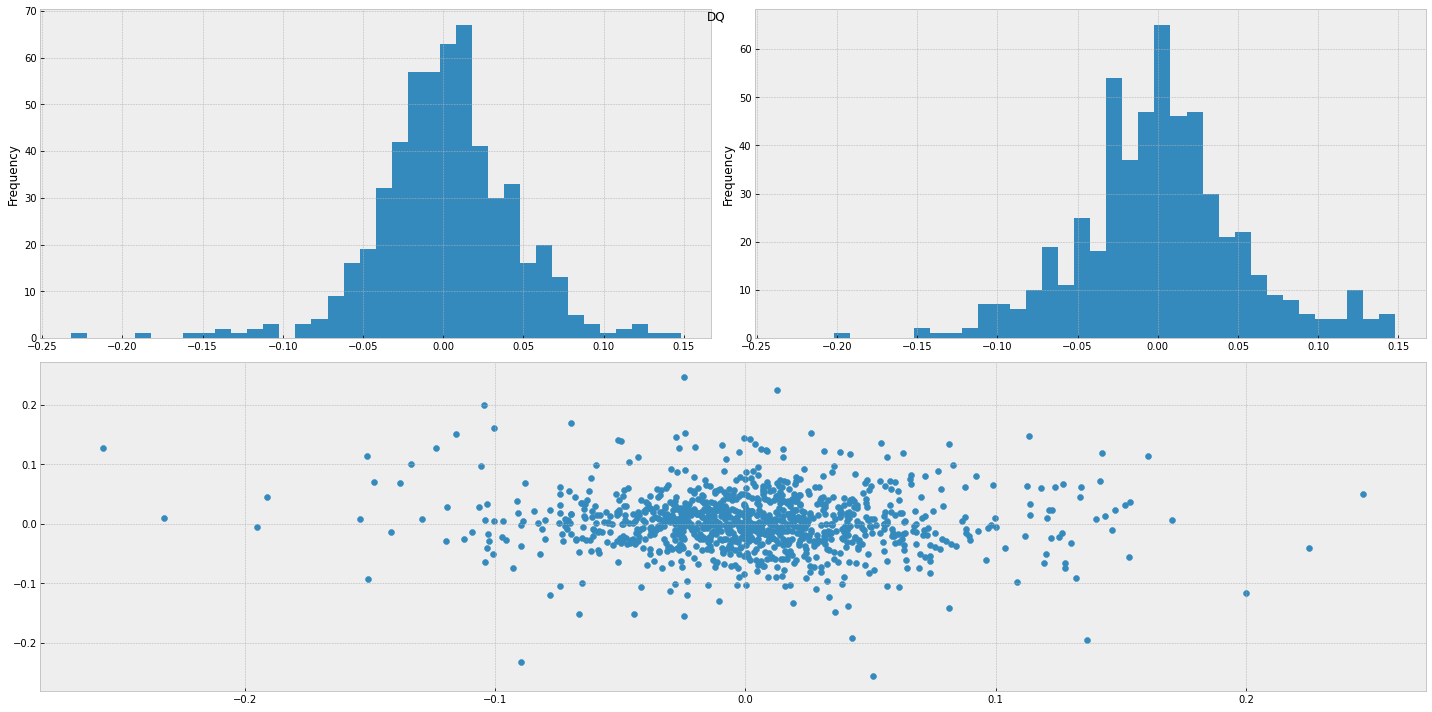

In [29]:
Vtest("DQ",compound_return)


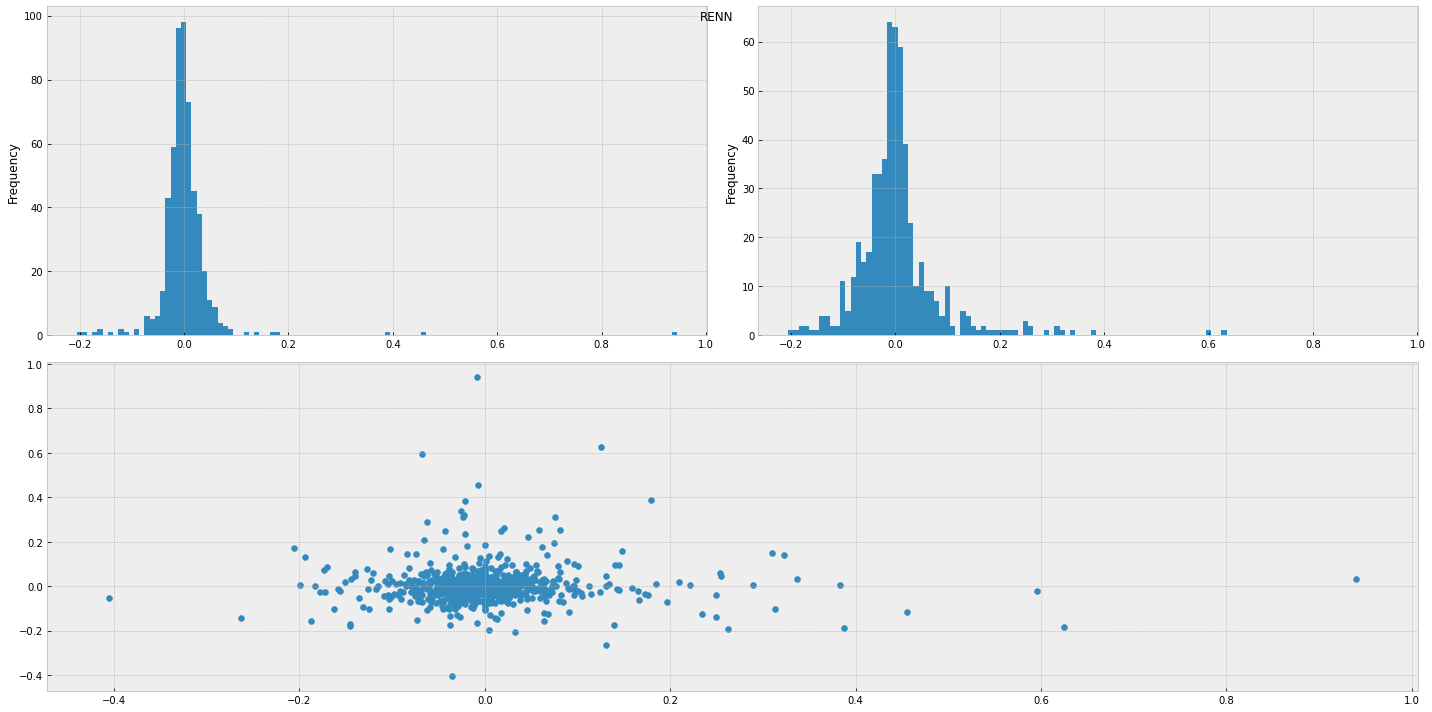

In [30]:
Vtest("RENN",compound_return)

## 4. Fitting a model and forecast
Then we try to fitting the model by time series analysis. Since all stock's log return are invarient ,we try the ARMA model first,and then try the ARIMA model. The fitted ARMA and ARIMA models are similar, and in stock "AACG", the ARIMA models fit better, therefore we choose the ARIMA model finally. According to the time serires plot below, the residual of all stock's model are normaly distributed. After choosing the model, we predict 21 days log return of each stock.

In [31]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [32]:
from numpy.linalg import LinAlgError
def ARMA(name,returns):
    name=returns[name]
    name.index = pd.DatetimeIndex(name.index.values,freq=returns.index.inferred_freq)
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    rng = range(1,5) # [0,1,2,3,4,5]
    for i in rng:
        for j in rng:
            try:
                tmp_mdl = smt.ARMA(name, order=(i, j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except (ValueError, LinAlgError) as e: continue


    #print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return(best_aic,best_order,best_mdl)

In [33]:
def ARIMA(name,returns):
    name=returns[name]
    name.index = pd.DatetimeIndex(name.index.values,freq=returns.index.inferred_freq)
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(name,order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    return(best_aic,best_order,best_mdl)

### ARMA and ARIMA model of SPI

aic: -1069.27119 | order: (1, 1)


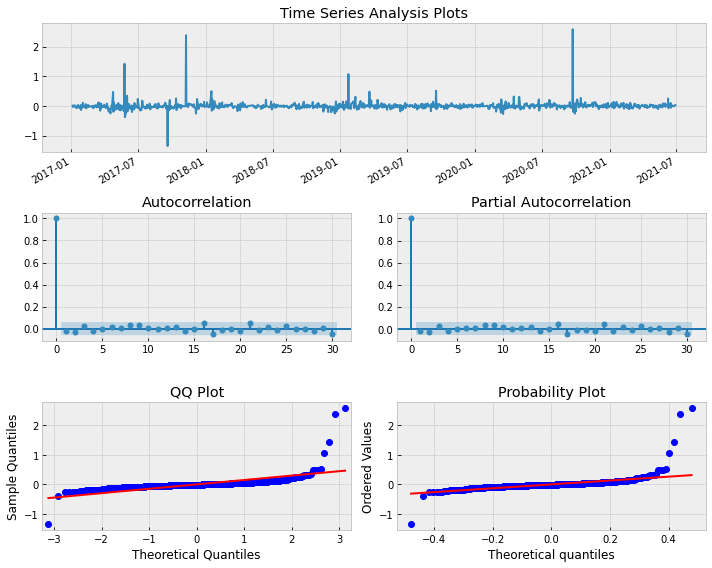

In [34]:
#ARMA
SPI_ARMA=ARMA("SPI",compound_return)
print('aic: {:6.5f} | order: {}'.format(SPI_ARMA[0], SPI_ARMA[1]))
_ = tsplot(SPI_ARMA[2].resid, lags=30)

aic: -1069.27119 | order: (1, 0, 1)


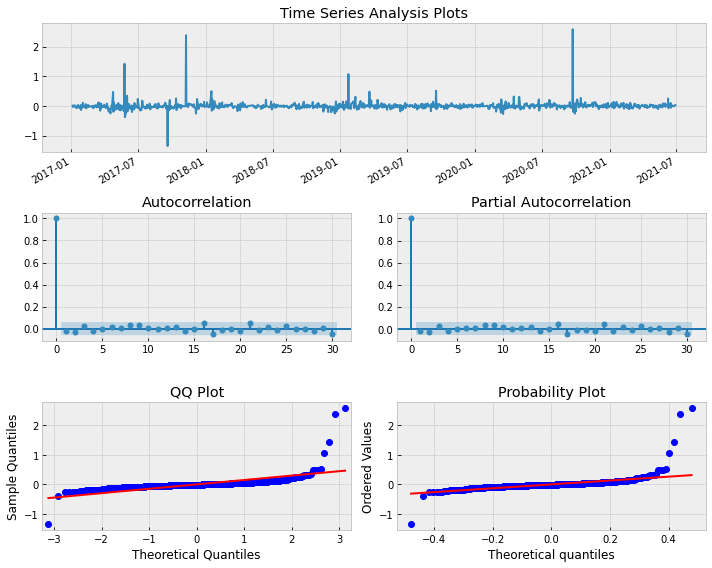

In [35]:
#ARIMA
SPI_ARIMA=ARIMA("SPI",compound_return)
print('aic: {:6.5f} | order: {}'.format(SPI_ARIMA[0], SPI_ARIMA[1]))
_ = tsplot(SPI_ARIMA[2].resid, lags=30)

### ARMA and ARIMA model of AACG

aic: -1966.18299 | order: (1, 1)


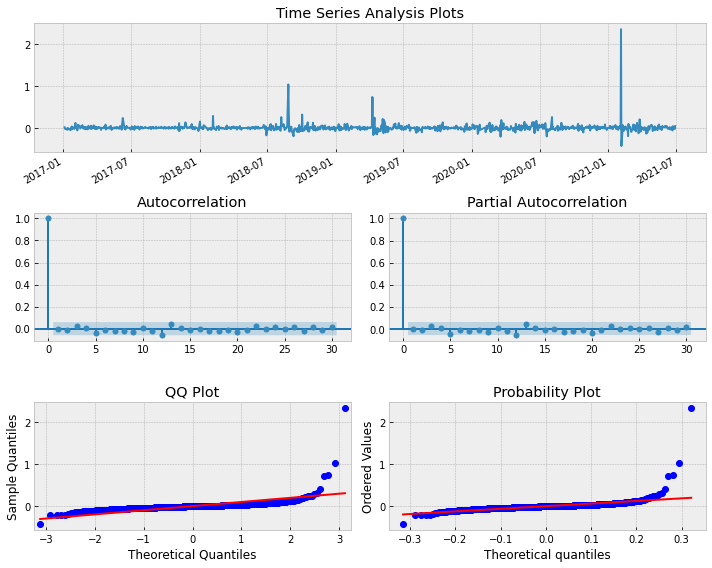

In [36]:
AACG_ARMA=ARMA("AACG",compound_return)
print('aic: {:6.5f} | order: {}'.format(AACG_ARMA[0], AACG_ARMA[1]))
_ = tsplot(AACG_ARMA[2].resid, lags=30)

aic: -1966.76062 | order: (2, 0, 0)


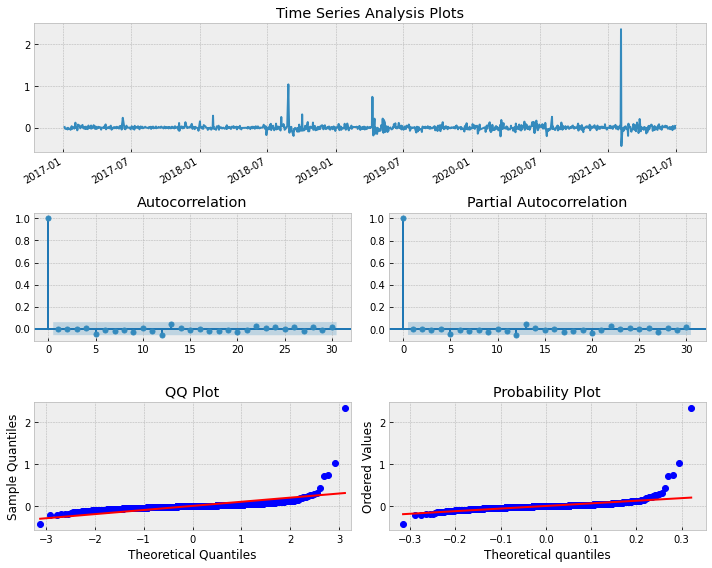

In [37]:
AACG_ARIMA=ARIMA("AACG",compound_return)
print('aic: {:6.5f} | order: {}'.format(AACG_ARIMA[0], AACG_ARIMA[1]))
_ = tsplot(AACG_ARIMA[2].resid, lags=30)

### ARMA and ARIMA model of BTB

aic: -1867.20125 | order: (2, 3)


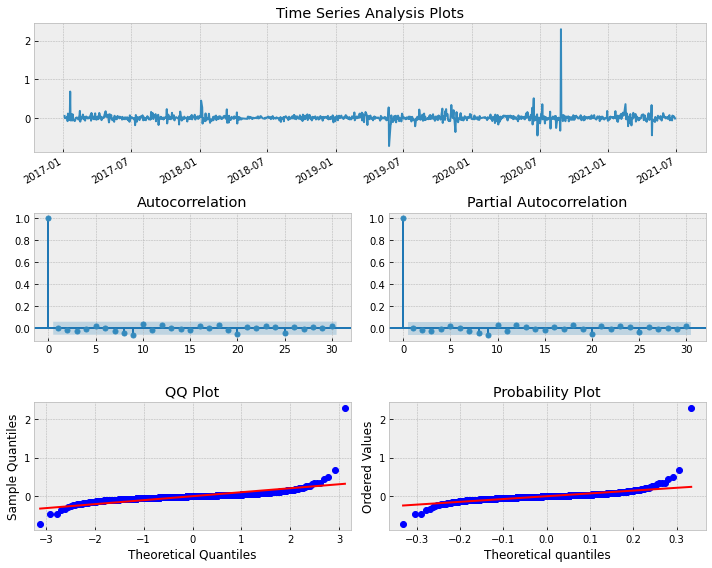

In [38]:
BTB_ARMA=ARMA("BTB",compound_return)
print('aic: {:6.5f} | order: {}'.format(BTB_ARMA[0], BTB_ARMA[1]))
_ = tsplot(BTB_ARMA[2].resid, lags=30)

aic: -1867.20125 | order: (2, 0, 3)


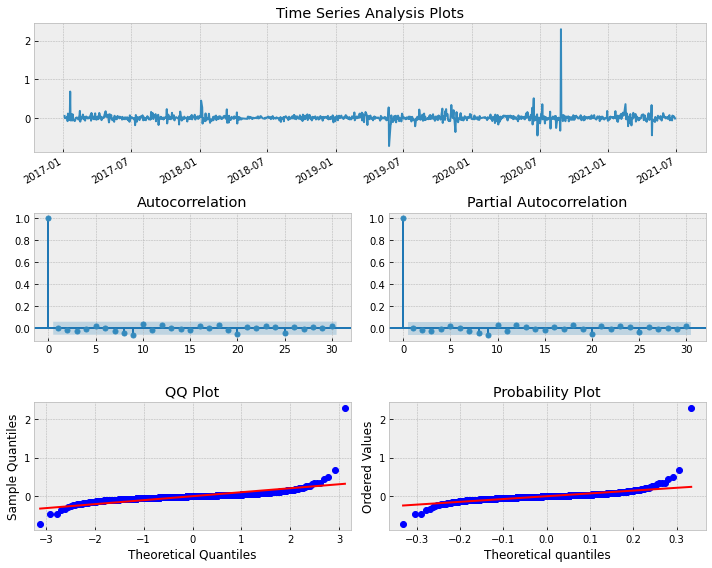

In [39]:
BTB_ARIMA=ARIMA("BTB",compound_return)
print('aic: {:6.5f} | order: {}'.format(BTB_ARIMA[0], BTB_ARIMA[1]))
_ = tsplot(BTB_ARIMA[2].resid, lags=30)

### ARMA and ARIMA model of MOXC

aic: -2204.16462 | order: (3, 4)


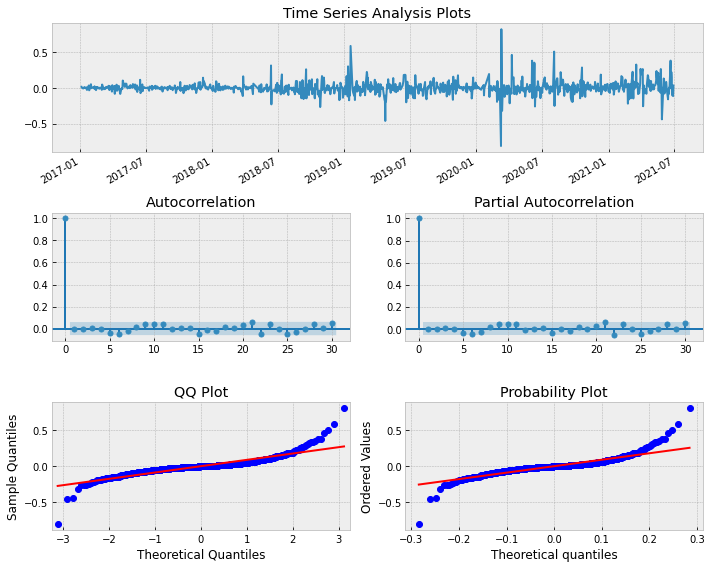

In [40]:
MOXC_ARMA=ARMA("MOXC",compound_return)
print('aic: {:6.5f} | order: {}'.format(MOXC_ARMA[0], MOXC_ARMA[1]))
_ = tsplot(MOXC_ARMA[2].resid, lags=30)

aic: -2204.16462 | order: (3, 0, 4)


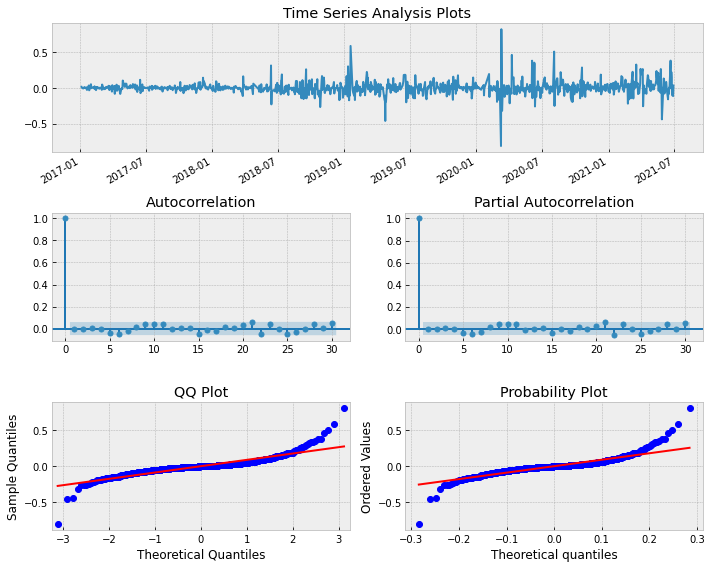

In [41]:
MOXC_ARIMA=ARIMA("MOXC",compound_return)
print('aic: {:6.5f} | order: {}'.format(MOXC_ARIMA[0], MOXC_ARIMA[1]))
_ = tsplot(MOXC_ARIMA[2].resid, lags=30)

### ARMA and ARIMA model of DQ


aic: -3455.98850 | order: (2, 2)


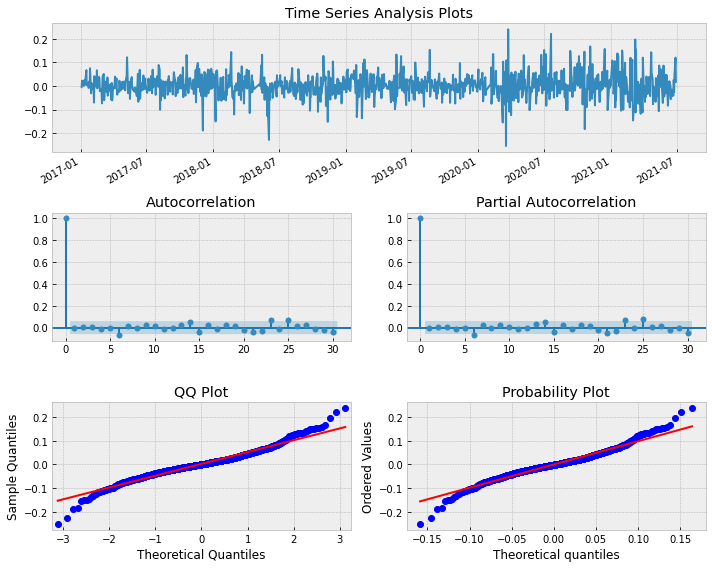

In [42]:
DQ_ARMA=ARMA("DQ",compound_return)
print('aic: {:6.5f} | order: {}'.format(DQ_ARMA[0], DQ_ARMA[1]))
_ = tsplot(DQ_ARMA[2].resid, lags=30)

aic: -3455.98850 | order: (2, 0, 2)


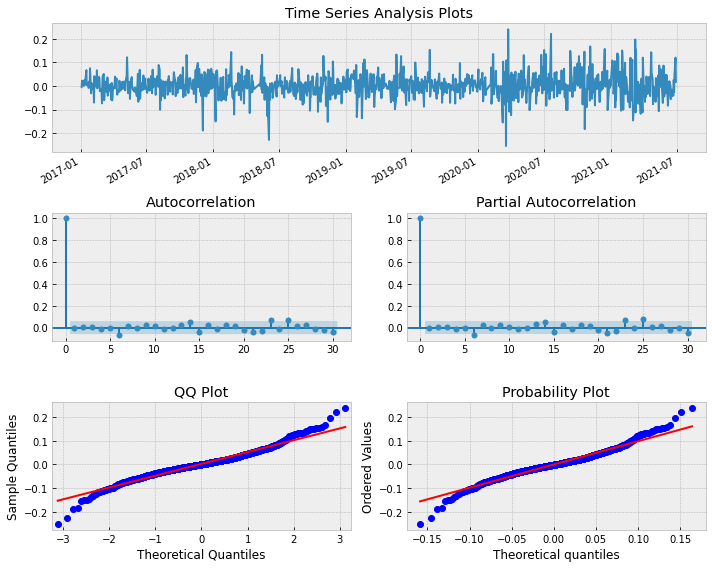

In [43]:
DQ_ARIMA=ARIMA("DQ",compound_return)
print('aic: {:6.5f} | order: {}'.format(DQ_ARIMA[0], DQ_ARIMA[1]))
_ = tsplot(DQ_ARIMA[2].resid, lags=30)

### ARMA and ARIMA model of RENN

aic: -2656.17651 | order: (2, 2)


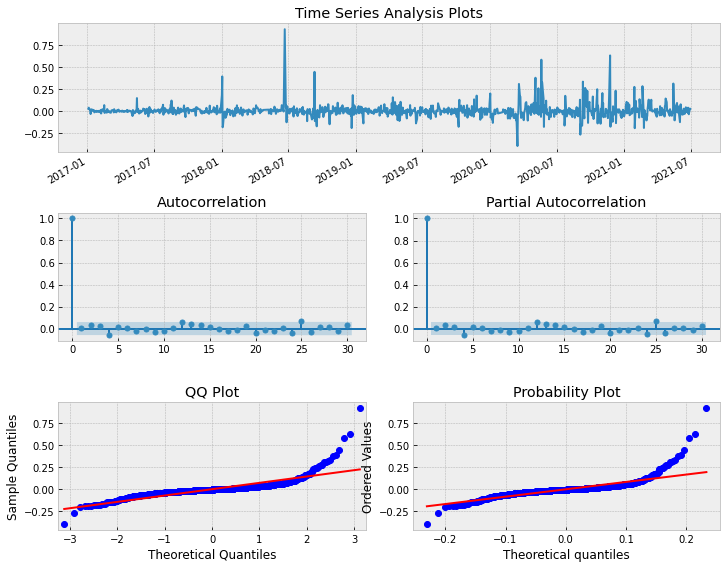

In [44]:
RENN_ARMA=ARMA("RENN",compound_return)
print('aic: {:6.5f} | order: {}'.format(RENN_ARMA[0], RENN_ARMA[1]))
_ = tsplot(RENN_ARMA[2].resid, lags=30)

aic: -2656.17651 | order: (2, 0, 2)


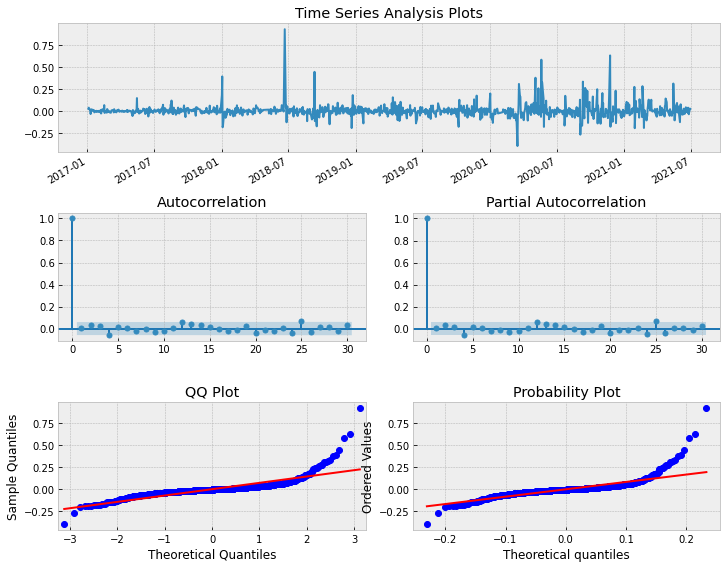

In [45]:
RENN_ARIMA=ARIMA("RENN",compound_return)
print('aic: {:6.5f} | order: {}'.format(RENN_ARIMA[0], RENN_ARIMA[1]))
_ = tsplot(RENN_ARIMA[2].resid, lags=30)

### Trend forecast

In [46]:
def fc(n_steps,mdl,ran):
    RENN_f, RENN_err95, RENN_ci95 = mdl.forecast(steps=n_steps)
    idx = pd.date_range(ran, periods=n_steps, freq='D')
    fc=pd.DataFrame(np.column_stack([RENN_f, RENN_ci95]), 
                         index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    return fc

In [47]:
### traning set fitting
SPI_test=fc(21,SPI_ARIMA[2],"2021-6-01")
AACG_test=fc(21,AACG_ARIMA[2],"2021-6-01")
BTB_test=fc(21,BTB_ARIMA[2],"2021-6-01")
MOXC_test=fc(21,MOXC_ARIMA[2],"2021-6-01")
DQ_test=fc(21,DQ_ARIMA[2],"2021-6-01")
RENN_test=fc(21,RENN_ARIMA[2],"2021-6-01")

<AxesSubplot:>

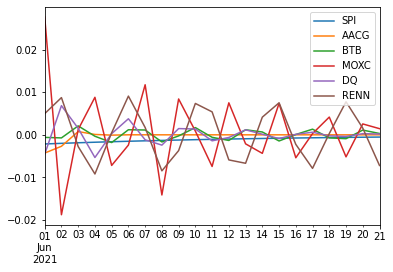

In [48]:
n_steps=21
idx = pd.date_range("2021-6-01", periods=n_steps, freq='D')
fc_test=pd.DataFrame(np.column_stack([SPI_test["forecast"], AACG_test["forecast"],BTB_test["forecast"],MOXC_test["forecast"],
                                    DQ_test["forecast"],RENN_test["forecast"]]),
                                    index=idx, columns=["SPI","AACG","BTB","MOXC","DQ","RENN"])
fc_test.plot()

<AxesSubplot:xlabel='Date'>

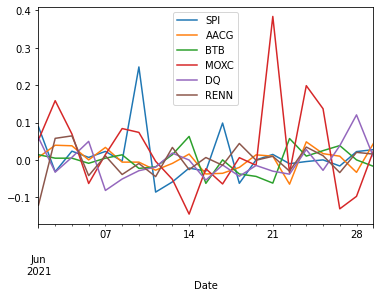

In [49]:
compound_return["2021-06"].plot()

In [50]:
##future 21 days data
SPI_fc=fc(21,SPI_ARIMA[2],"2021-6-29")
AACG_fc=fc(21,AACG_ARIMA[2],"2021-6-29")
BTB_fc=fc(21,BTB_ARIMA[2],"2021-6-29")
MOXC_fc=fc(21,MOXC_ARIMA[2],"2021-6-29")
DQ_fc=fc(21,DQ_ARIMA[2],"2021-6-29")
RENN_fc=fc(21,RENN_ARIMA[2],"2021-6-29")

<AxesSubplot:>

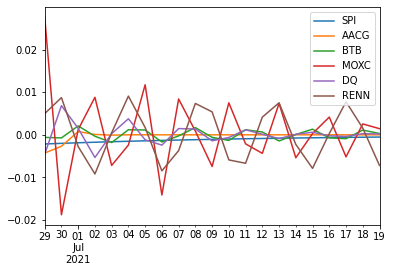

In [51]:
idx = pd.date_range("2021-6-29", periods=n_steps, freq='D')
FC_21=pd.DataFrame(np.column_stack([SPI_fc["forecast"], AACG_fc["forecast"],BTB_fc["forecast"],MOXC_fc["forecast"],
                                    DQ_fc["forecast"],RENN_fc["forecast"]]),
                                    index=idx, columns=["SPI","AACG","BTB","MOXC","DQ","RENN"])
FC_21.plot()

In [52]:
asset=["SPI","AACG","BTB","MOXC","DQ","RENN"]
Start="2021-06-29"
End="2021-07-15"
test_df = yf.download(asset, start=Start,end=End, adjusted=True)

[*********************100%***********************]  6 of 6 completed


<AxesSubplot:xlabel='Date'>

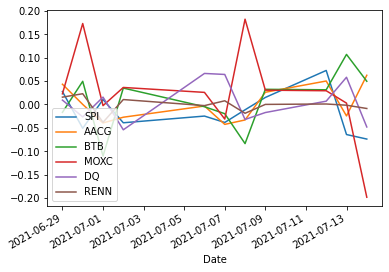

In [53]:
return_test=np.log(test_df["Adj Close"]/test_df["Adj Close"].shift(1)).dropna()
return_test= return_test[asset]
return_test.plot()

## Conclusion 

According to the plot of test predict data plot.Our model have a good fit of tranning dataset. The parrtern we predict are similar to the traiining dataset. However, the sample size are simillar,which means the model may not predict future trend prefectly.